In [1]:
import geopandas as gpd
import pandas as pd

import networkx as nx
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=(8,8)

training_folder = r'../'
gis_folder = training_folder +r'gis/corse/'
data_folder = training_folder +r'data/corse/'

# chargement des données

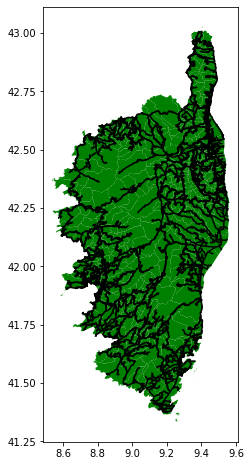

In [2]:
edges = gpd.read_file(gis_folder + r'osmdrive/edges/edges.shp')
nodes = gpd.read_file(gis_folder + r'osmdrive/nodes/nodes.shp')

stops = gpd.read_file(gis_folder + r'stops_corse.shp')
communes = gpd.read_file(gis_folder + r'communes_corse.shp')

edges.plot(ax=communes.plot(color='green'), color='black')
plt.savefig(r'../plot/edges.png', bbox_inches='tight')

In [3]:
commune_nearest_node = pd.read_csv(data_folder + 'commune_nearest_node.csv').astype(str)

In [4]:
stop_nearest_node = pd.read_csv(data_folder + 'stop_nearest_node.csv').astype(str)

In [5]:
stop_nearest_node.head(1)

,stop,stop_node
0,0,394695922


In [6]:
commune_nearest_node.head(1)

,commune,commune_node
0,2A001,5795014130


In [7]:
len(commune_nearest_node)

360

In [8]:
communes.head(1)

,insee,geometry
0,2B047,"POLYGON ((8.99313 42.32554, 8.99489 42.32614, ..."


In [9]:
edges[['from', 'to']] = edges[['from', 'to']]
edges['length'] = edges['length'].astype(float)

# construction du graphe routier

In [10]:
# création du graphe orienté
dg = nx.DiGraph()

In [11]:
# on va travailler dans un graphe orienté
# on souhaite donc ajouter les arêtes a -> b et b -> a pour chaque route
# on aurait aussi pu travailler avec un graphe non orienté
direct = edges[['from', 'to', 'length']].values.tolist()
indirect = edges[['to', 'from', 'length']].values.tolist()

In [12]:
# ajout de toutes les routes au graphe
dg.add_weighted_edges_from(direct)
dg.add_weighted_edges_from(indirect)

# Calcul des distances nœud à nœud dans le graphe 
pour les nœuds les plus proches des gares

In [13]:
node_single_sources = dict()

for stop_node in tqdm(list(stop_nearest_node['stop_node'])):
    
    # pour chacun des nœuds associé à une gare
    # on calcule la distance vers tous les nœuds du réseau
    # on stocke cette valeur dans un dictionnaire: la clé est le nœud de départ
    lengths = nx.single_source_dijkstra_path_length(dg, stop_node)
    node_single_sources[stop_node] = lengths

100%|██████████| 50/50 [00:02<00:00, 20.14it/s]


In [14]:
# node_single_source est un dictionnaire imbriqué
source = '394695922'
target = '1798240601'
node_single_sources[source][target] # accès aux valeurs d'un dictionnaire

137158.482

In [15]:
# on parcourt le dictionnaire imbriqué pour le transformer en liste de listes
node_node_graph_distance = []
for stop_node, lengths in node_single_sources.items():
    for node, length in lengths.items():
        node_node_graph_distance.append((stop_node, node, length))

In [16]:
node_node = pd.DataFrame(node_node_graph_distance, columns=['stop_node', 'commune_node', 'distance'])

In [17]:
node_node.head()

,stop_node,commune_node,distance
0,394695922,394695922,0.000
1,394695922,4969278512,58.127
2,394695922,4969278511,98.050
3,394695922,6315391185,190.112
4,394695922,4969278502,201.908


In [18]:
node_node.to_csv(data_folder+'node_node_graph_distance.csv', index=False)

# Contrôle

In [19]:
merged = pd.merge(
    nodes, 
    node_node.groupby('commune_node')[['distance']].min(),
    left_on='osmid',
    right_index=True
)

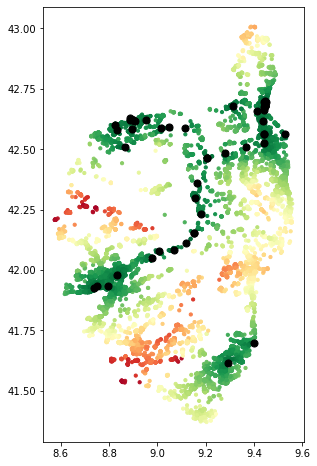

In [20]:
stops.plot(
    ax= merged.plot(
        column='distance', 
        k=100, 
        cmap='RdYlGn_r', 
        markersize=10
    ),
    markersize=50,
    color='black'
)
plt.savefig(r'../plot/node_distance.png', bbox_inches='tight')

In [21]:
merged.to_file(gis_folder + 'accessibility_nodes.shp')

C:\Users\rgoix\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
